In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import missingno as msno

In [2]:
# lat and lon for locations (according to google)
# Emmeloord
emlat = 52.7121
emlon = 5.7550
#Lelystad
lelat =52.5185
lelon = 5.4714
# Rittershausen
rilat = 50.8443
rilon = 8.2853
# Sommepy
solat =49.2506
solon =4.5571
#  Herchsheim
helat =49.6317
helon =9.9446
# Lamotte
lalat =43.4931
lalon =6.5360
# Mattenkofen
malat =48.7817
malon =12.7361
# Pithiviers
pilat =48.1734
pilon = 2.2558
#Oberviehhausen 
oblat = 48.7078
oblon = 12.8629
# Vierhoefen 
vilat= 53.2656
vilon= 10.2176
# Bautzen
balat= 51.1823
balon= 14.4238
# Stadthagen
stlat= 52.3231
stlon= 9.1926
# Goderville
golat= 49.6460
golon= 0.3675
# Soest
soelat= 51.5714
soelon= 8.1105
# Anklam
anlat= 53.8503
anlon= 13.6960
# Hamm
halat = 51.6739
halon = 7.8160


In [3]:
#import the data as a dataframe
df = pd.read_csv('data/DatenfürGina_recorded2.csv', delimiter=";",decimal=',')
#lower case the name of the columns
df.columns = df.columns.str.lower()
#rename the columns to remove the name 'gina'
df.rename(columns={'ginams!': 'ms_comp', 'ginaotype!': 'otype_comp', 'ginapoll!': 'pollinator_comp', 'ginaseednames!': 'seednames_coded'}, inplace=True)
#remove the numbers from the fieldid
df['fieldid'] = df['fieldid'].replace(r'1', r'', regex=True)
df['fieldid'] = df['fieldid'].replace(r'_2', r'', regex=True)
df['fieldid'] = df['fieldid'].replace(r'2', r'', regex=True)
#drop the columns with unnecessary information after discussion with the stakeholder
df.drop(['cropid','bm', 'breedid', 'locationid', 'fieldblock', 'fieldsubblock', 'filler',
       'labnr', 'layoutnr','plotid', 'plotindex', 'rep','spectraname', 'trial', 'year', 'anzahl', 'standardind'], axis=1, inplace=True)
#remove one outlier with negative value
df = df[df.betaine_nir >= 0]
#exclude missing value (0.19 %)
df = df.dropna()

In [4]:
#Create station_location column
df['station_location'] = df['fieldid']
#replace stations locations
df['station_location'] = df['station_location'].replace(r'Hamm', r'Soest', regex=True)
df['station_location'] = df['station_location'].replace(r'Oberviehhausen', r'Mattenkofen', regex=True)
df['station_location'] = df['station_location'].replace(r'Vierhöfen', r'Mattenkofen', regex=True)

In [5]:
df.station_location.unique()

array(['Emmeloord', 'Lelystad', 'Rittershausen', 'Sommepy', 'Herchsheim',
       'Lamotte', 'Mattenkofen', 'Pithiviers', 'Vierhoefen', 'Bautzen',
       'Stadthagen', 'Goderville', 'Soest', 'Anklam'], dtype=object)

In [6]:
# import weather data, rename the columns in english and at the same time rename Unnamed1 to country and location to station-location
weather_column_names = (['station_location',
'country',
'Date_time',
'Day', 
'Month', 
'Year', 
'Hour',
'air_temperature_avg',
'air_temperature_max',
'air_temperature_min',
'dew_point_avg',
'dew_point_min',
'solar_radiation',
'saturation_VPD_avg',
'saturation_VPD_min',
'relative_humidity_avg',
'relative_humidity_max',
'relative_humidity_min',
'precipitation',
'leaf_wetness',
'wind_speed_avg',
'wind_speed_max',
'wind_speed_gusts',
'wind_direction',
'EAG_soil_moisture_1',
'EAG_soil_moisture_2',
'EAG_soil_moisture_3',
'EAG_soil_moisture_4',
'EAG_soil_moisture_5',
'EAG_soil_moisture_6',
'soil_salinity_1',
'soil_salinity_2',
'soil_salinity_3',
'soil_salinity_4',
'soil_salinity_5',
'soil_salinity_6',
'soil_temperature_1_vg',
'soil_temperature_1_max',
'soil_temperature_1_min',
'soil_temperature_2_vg',
'soil_temperature_2_max',
'soil_temperature_2_min',
'soil_temperature_3_vg',
'soil_temperature_3_max',
'soil_temperature_3_min',
'soil_temperature_4_vg',
'soil_temperature_4_max',
'soil_temperature_4_min',
'soil_temperature_5_vg',
'soil_temperature_5_max',
'soil_temperature_5_min',
'soil_temperature_6_vg',
'soil_temperature_6_max',
'soil_temperature_6_min',
'solar_panel',
'battery',
'deltaT_avg',
'deltaT_max',
'deltaT_min',
'ET0'])
# import csv file
df_weatherstations = pd.read_csv('data/wetterdaten_all-stations_hourly.csv', delimiter=';', decimal=',', header=0, names=weather_column_names)
#lower case the name of the columns, rename a col
df_weatherstations.columns = df_weatherstations.columns.str.lower()
#df_weatherstations.rename(columns={'unnamed_1': 'country'}, inplace=True)

In [7]:
#change date to datetime format and extract month and day, directly changing the month and day columns
df_weatherstations['date_time'] = pd.to_datetime(df_weatherstations['date_time'], yearfirst=True, format="%Y-%m-%d %H:%M:%S")
df_weatherstations['month'] = df_weatherstations['date_time'].dt.month
df_weatherstations['day'] = df_weatherstations['date_time'].dt.day

In [8]:
# simplify weatherdata for now
df_weatherstations.drop(['date_time', 'year', 'hour','dew_point_avg', 'dew_point_min', 'wind_speed_avg', 'wind_speed_max', 
                         'wind_speed_gusts', 'wind_direction','solar_panel', 'battery', 'saturation_vpd_avg', 'saturation_vpd_min'], 
                         axis=1, 
                         inplace=True
                         )

In [9]:
# create shell for monthly calculations of weatherdata
df_weatherstations_monthly = df_weatherstations[['station_location', 'country', 'day', 'month']]

In [10]:
# air temp monthly average 
df_weatherstations_monthly['air_temperature_avg_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['air_temperature_avg'].transform('mean')
df_weatherstations_monthly['air_temperature_max_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['air_temperature_max'].transform('mean')
df_weatherstations_monthly['air_temperature_min_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['air_temperature_min'].transform('mean')

# soil monthly average
df_weatherstations_monthly['eag_soil_moisture_1_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['eag_soil_moisture_1'].transform('mean')
df_weatherstations_monthly['eag_soil_moisture_2_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['eag_soil_moisture_2'].transform('mean')
df_weatherstations_monthly['eag_soil_moisture_3_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['eag_soil_moisture_3'].transform('mean')
df_weatherstations_monthly['eag_soil_moisture_4_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['eag_soil_moisture_4'].transform('mean')
df_weatherstations_monthly['eag_soil_moisture_5_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['eag_soil_moisture_5'].transform('mean')
df_weatherstations_monthly['eag_soil_moisture_6_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['eag_soil_moisture_6'].transform('mean')

df_weatherstations_monthly['soil_salinity_1_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_salinity_1'].transform('mean')
df_weatherstations_monthly['soil_salinity_2_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_salinity_2'].transform('mean')
df_weatherstations_monthly['soil_salinity_3_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_salinity_3'].transform('mean')
df_weatherstations_monthly['soil_salinity_4_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_salinity_4'].transform('mean')
df_weatherstations_monthly['soil_salinity_5_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_salinity_5'].transform('mean')
df_weatherstations_monthly['soil_salinity_6_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_salinity_6'].transform('mean')

df_weatherstations_monthly['soil_temperature_1_vg_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_1_vg'].transform('mean')
df_weatherstations_monthly['soil_temperature_2_vg_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_2_vg'].transform('mean')
df_weatherstations_monthly['soil_temperature_3_vg_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_3_vg'].transform('mean')
df_weatherstations_monthly['soil_temperature_4_vg_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_4_vg'].transform('mean')
df_weatherstations_monthly['soil_temperature_5_vg_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_5_vg'].transform('mean')
df_weatherstations_monthly['soil_temperature_6_vg_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_6_vg'].transform('mean')

df_weatherstations_monthly['soil_temperature_1_min_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_1_min'].transform('mean')
df_weatherstations_monthly['soil_temperature_2_min_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_2_min'].transform('mean')
df_weatherstations_monthly['soil_temperature_3_min_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_3_min'].transform('mean')
df_weatherstations_monthly['soil_temperature_4_min_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_4_min'].transform('mean')
df_weatherstations_monthly['soil_temperature_5_min_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_5_min'].transform('mean')
df_weatherstations_monthly['soil_temperature_6_min_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_6_min'].transform('mean')

df_weatherstations_monthly['soil_temperature_1_max_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_1_max'].transform('mean')
df_weatherstations_monthly['soil_temperature_2_max_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_2_max'].transform('mean')
df_weatherstations_monthly['soil_temperature_3_max_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_3_max'].transform('mean')
df_weatherstations_monthly['soil_temperature_4_max_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_4_max'].transform('mean')
df_weatherstations_monthly['soil_temperature_5_max_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_5_max'].transform('mean')
df_weatherstations_monthly['soil_temperature_6_max_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['soil_temperature_6_max'].transform('mean')

#sunshine
df_weatherstations_monthly['solar_radiation_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['solar_radiation'].transform('sum')

#humidity
df_weatherstations_monthly['relative_humidity_avg_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['relative_humidity_avg'].transform('mean')
df_weatherstations_monthly['relative_humidity_max_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['relative_humidity_max'].transform('mean')
df_weatherstations_monthly['relative_humidity_min_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['relative_humidity_min'].transform('mean')
df_weatherstations_monthly['precipitation_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['precipitation'].transform('sum')
df_weatherstations_monthly['leaf_wetness_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['leaf_wetness'].transform('mean')


/var/folders/r8/96vp6rrx3633scm80v59y52c0000gn/T/ipykernel_1286/1288574712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weatherstations_monthly['air_temperature_avg_monthly'] = df_weatherstations.groupby(['station_location', 'month'])['air_temperature_avg'].transform('mean')
/var/folders/r8/96vp6rrx3633scm80v59y52c0000gn/T/ipykernel_1286/1288574712.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weatherstations_monthly['air_temperature_max_monthly'] = df_weatherstations.groupby(['station_lo

In [11]:
# drop day columns and remove duplicate rows
df_weatherstations_monthly.drop(['day'], axis=1, inplace=True)
df_weatherstations_monthly.drop_duplicates(keep='first', inplace=True)
df_weatherstations_monthly.shape

/var/folders/r8/96vp6rrx3633scm80v59y52c0000gn/T/ipykernel_1286/3563914625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weatherstations_monthly.drop(['day'], axis=1, inplace=True)
/var/folders/r8/96vp6rrx3633scm80v59y52c0000gn/T/ipykernel_1286/3563914625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weatherstations_monthly.drop_duplicates(keep='first', inplace=True)


(88, 42)

In [12]:
# PICKLE RICK
df_weatherstations_monthly.to_pickle('data/df_weatherstations_monthly.pkl')
df.to_pickle('data/sugarbeet.pkl')


#### Data Vis


<AxesSubplot:xlabel='month', ylabel='soil_temperature_1_vg_monthly'>

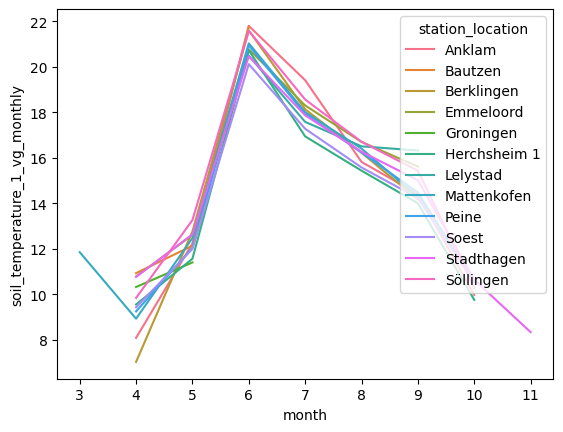

In [13]:
# plot timeline of soil temperature at 30cm depth per location
sns.lineplot(data=df_weatherstations_monthly.groupby(['station_location']).value_counts(), x='month', y='soil_temperature_1_vg_monthly', hue='station_location')

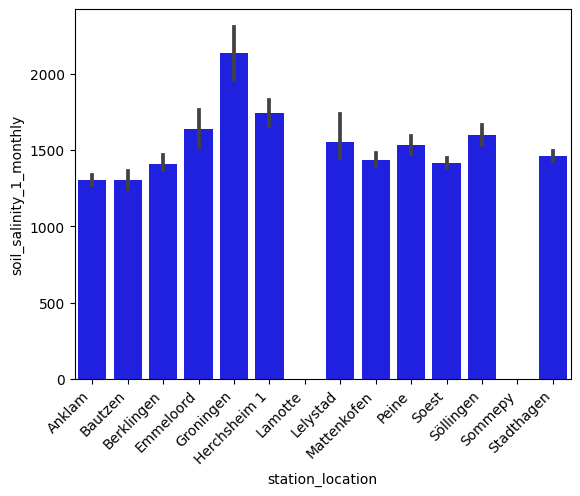

In [14]:
# plot amount of soil salinity at 30cm depth per location
fig = sns.barplot(data=df_weatherstations_monthly, x='station_location', y='soil_salinity_1_monthly', color='blue')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right');

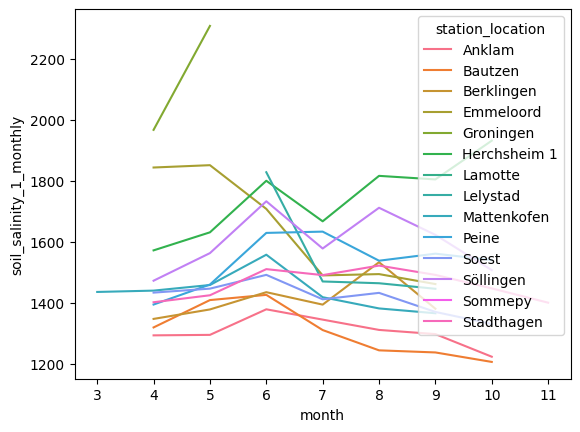

In [15]:
# plot timeline of soil salinity at 30cm depth per location
fig = sns.lineplot(data=df_weatherstations_monthly, x='month', y='soil_salinity_1_monthly', hue='station_location', ci=None)

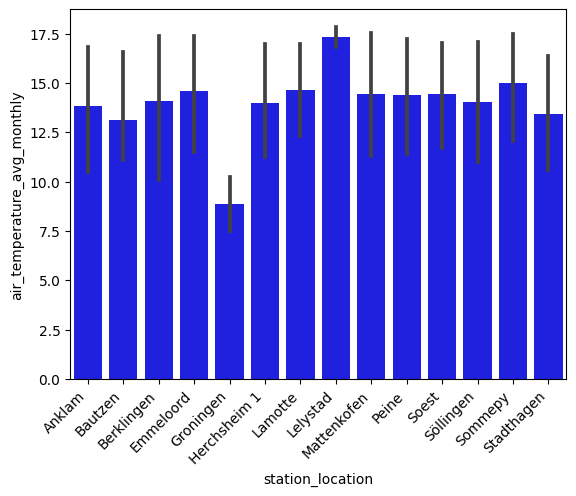

In [18]:
# plot amount of soil salinity at 30cm depth per location
fig = sns.barplot(data=df_weatherstations_monthly, x='station_location', y='air_temperature_avg_monthly', color='blue')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right');